<a href="https://colab.research.google.com/github/moujibhmaoui/ENERGIE/blob/main/TITANIC_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing necessary libraries for data analysis and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [ ]:
# Load the dataset
file_path = '/content/drive/MyDrive/titanic.xls'
data = pd.read_excel(file_path)

In [ ]:
# Drop unnecessary columns
columns_to_drop = ['name', 'ticket', 'cabin', 'boat', 'body', 'home.dest']
data = data.drop(columns=columns_to_drop, errors='ignore')

In [ ]:
# Display the first few rows of the DataFrame
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,female,29.0000,0,0,211.3375,S
1,1,1,male,0.9167,1,2,151.5500,S
2,1,0,female,2.0000,1,2,151.5500,S
3,1,0,male,30.0000,1,2,151.5500,S
4,1,0,female,25.0000,1,2,151.5500,S


In [ ]:
# Replace missing values in the 'Age' column with the mean
data['age'].fillna(data['age'].mean(), inplace=True)

In [ ]:
# Drop rows with missing values in the 'fare' or 'embarked' columns
data = data.dropna(subset=['fare', 'embarked'])

In [ ]:
# Display the number of missing values per column
print(data.isnull().sum())

pclass      0
survived    0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64


In [ ]:
# Convert 'sex' and 'embarked' to numerical values
data['sex'] = data['sex'].map({'male': 0, 'female': 1})
data['embarked'] = data['embarked'].map({'S': 0, 'C': 1, 'Q': 2})

In [ ]:
# Separate features (X) and target (y)
X = data[['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex', 'embarked']]
y = data['survived']

In [ ]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
# Create a pipeline for the models
models = [
    ('logreg', LogisticRegression(max_iter=1000)),
    ('svm', SVC(probability=True)),
    ('rf', RandomForestClassifier())
]

best_score = 0
best_model_name = None
best_model = None

# GridSearch for each model
for name, model in models:
    pipeline = Pipeline(steps=[('model', model)])
    param_grid = {}

    if name == 'logreg':
        param_grid = {'model__C': [0.1, 1, 10]}
    elif name == 'svm':
        param_grid = {'model__C': [0.1, 1, 10], 'model__kernel': ['linear', 'rbf']}
    elif name == 'rf':
        param_grid = {'model__n_estimators': [50, 100, 200]}

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_estimator = grid_search.best_estimator_

    y_pred = best_estimator.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Classification report for {name}:\n{classification_report(y_test, y_pred)}")

    if accuracy > best_score:
        best_score = accuracy
        best_model_name = name
        best_model = best_estimator

print(f"\nThe best performing model is: {best_model_name} with an accuracy of {best_score:.4f}")




Best parameters for logreg: {'model__C': 10}
Classification report for logreg:
              precision    recall  f1-score   support

           0       0.80      0.86      0.82       154
           1       0.77      0.69      0.73       108

    accuracy                           0.79       262
   macro avg       0.78      0.77      0.78       262
weighted avg       0.79      0.79      0.78       262

Best parameters for svm: {'model__C': 0.1, 'model__kernel': 'linear'}
Classification report for svm:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       154
           1       0.74      0.66      0.70       108

    accuracy                           0.76       262
   macro avg       0.76      0.75      0.75       262
weighted avg       0.76      0.76      0.76       262

Best parameters for rf: {'model__n_estimators': 200}
Classification report for rf:
              precision    recall  f1-score   support

           0       0.81     

In [51]:
# Obtain feature importances for the best model
if best_model_name == 'rf':
    # For RandomForest
    importances = best_model.named_steps['model'].feature_importances_
    feature_names = X.columns
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print("\nFeature Importances for RandomForest:")
    print(feature_importance_df)

    # Select important features
    important_features = feature_importance_df[feature_importance_df['Importance'] > 0.1]['Feature']  # arbitrary threshold
    X_important = X[important_features]

elif best_model_name == 'logreg':
    # For Logistic Regression
    coef = best_model.named_steps['model'].coef_[0]
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': coef})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print("\nFeature Importances for Logistic Regression:")
    print(feature_importance_df)

elif best_model_name == 'svm':
    # For SVM, use coefficients if linear kernel
    if 'linear' in grid_search.best_params_['model__kernel']:
        coef = best_model.named_steps['model'].coef_[0]
        feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': coef})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

        print("\nFeature Importances for SVM (Linear Kernel):")
        print(feature_importance_df)

        # Select important features
        important_features = feature_importance_df[feature_importance_df['Importance'] > 0.1]['Feature']  # arbitrary threshold
        X_important = X[important_features]
    else:
        print("SVM with non-linear kernel does not provide feature importances directly.")
        X_important = X



Feature Importances for Logistic Regression:
    Feature  Importance
5       sex    2.596096
6  embarked    0.225322
4      fare    0.000313
1       age   -0.033735
3     parch   -0.038735
2     sibsp   -0.275309
0    pclass   -1.078686


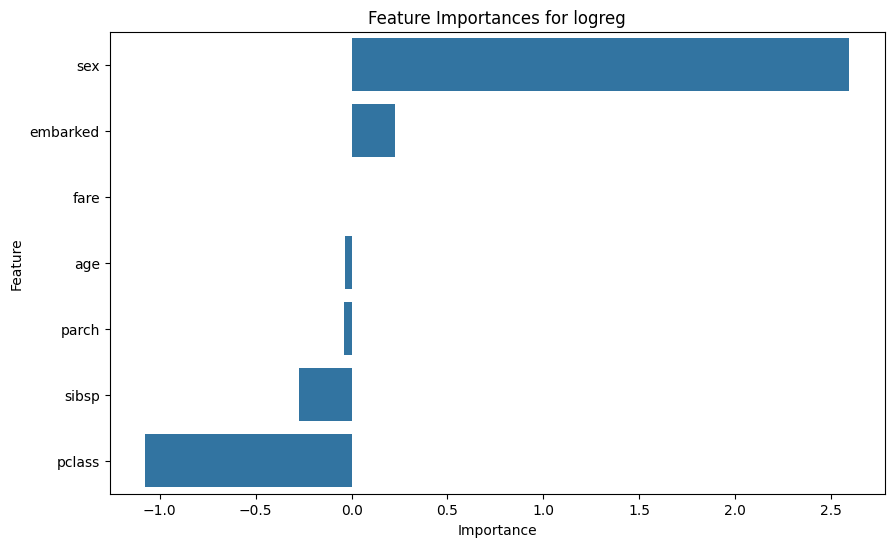

In [55]:
# Display feature importances for the best-performing model
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title(f"Feature Importances for {best_model_name}")
plt.show()